# 04: Inference

In this notebook, we'll use the trained model to make predictions on new NAIP imagery.

In [18]:
import tensorflow as tf
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio

from naip_cnn.inference import NAIPTFRecord
from naip_cnn.models import ModelRun

## Load the Model

First, we'll load and inspect the previously trained model.

In [23]:
run = ModelRun.from_filename("CNN_v2-MAL2016_CanyonCreek-1-30-150x150-150-cover-RGBN")
run.model.summary()

Model: "CNN_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      1184      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 25)                20736

## Run Inference

Inference is run on NAIP images that were exported as TFRecords in the previous notebook. Before continuing, make sure to wait for all Earth Engine exports to complete (you can check progress in the [task manager](https://code.earthengine.google.com/tasks)) and download the exported files to local storage.

In [28]:
naip = NAIPTFRecord(
    id="MAL", footprint=run.dataset.footprint, res=run.dataset.naip_res, year=2016
)

### Generate Predictions

Now we can use the model to generate predictions on the input images.

In [33]:
pred = naip.predict(run=run, verbose=1)

422/422 [==============================] - 71s 169ms/step


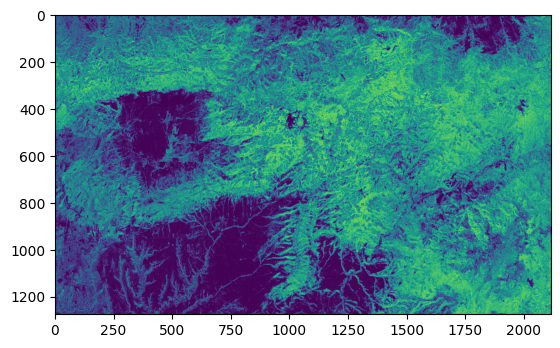

In [35]:
plt.imshow(pred, vmin=0, vmax=100)

## Export Predictions

Finally, we can export the predicted map to a raster image.

In [44]:
naip.export_prediction(pred=pred, run=run)